In [24]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
# Paths to the data
train_data_path = r'C:\Users\Praphul\Downloads\Human Action Recognition_New/train'
test_data_path = r'C:\Users\Praphul\Downloads\Human Action Recognition_New/test'

In [30]:
#Apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

In [31]:
# Create DataLoader for training and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

#### Run all the cells above till here.

### Load the Pre-trained ResNet Model

In [36]:
# Load the pre-trained ResNet model
resnet = models.resnet50(pretrained=True)  # You can change to resnet18, resnet34, resnet101, etc. based on your requirement

# Freeze all the feature extractor layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes (5 classes)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 5)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

In [34]:
import matplotlib.pyplot as plt

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

Epoch [1/20], Train Loss: 0.7098, Train Accuracy: 76.11%
Test Loss: 0.3619, Test Accuracy: 89.84%
Updated best model with accuracy: 89.84%
Epoch [2/20], Train Loss: 0.3771, Train Accuracy: 87.79%
Test Loss: 0.2984, Test Accuracy: 90.48%
Updated best model with accuracy: 90.48%
Epoch [3/20], Train Loss: 0.3196, Train Accuracy: 89.30%
Test Loss: 0.2712, Test Accuracy: 90.63%
Updated best model with accuracy: 90.63%
Epoch [4/20], Train Loss: 0.3043, Train Accuracy: 88.85%
Test Loss: 0.2961, Test Accuracy: 89.84%
Epoch [5/20], Train Loss: 0.3122, Train Accuracy: 88.99%
Test Loss: 0.3094, Test Accuracy: 88.57%
Epoch [6/20], Train Loss: 0.2710, Train Accuracy: 90.34%
Test Loss: 0.2816, Test Accuracy: 91.11%
Epoch [7/20], Train Loss: 0.2602, Train Accuracy: 90.59%
Test Loss: 0.2608, Test Accuracy: 90.48%
Updated best model with accuracy: 90.48%
Epoch [8/20], Train Loss: 0.2607, Train Accuracy: 91.34%
Test Loss: 0.2719, Test Accuracy: 91.11%
Epoch [9/20], Train Loss: 0.2562, Train Accuracy: 90

### Plot: Epochs vs Train Loss and Epochs vs Test Loss

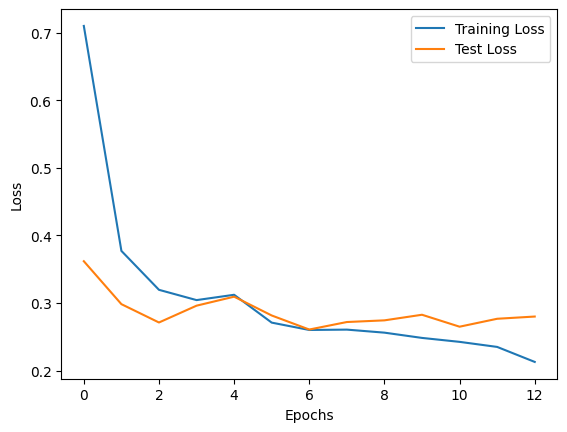

In [39]:
# Plotting the epochs vs training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()